In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from catboost import *
import shap
from time import time

In [45]:
# incidents = read_data()
incidents_initial = pd.read_csv('data/cleaned_data_no_zeros.csv', sep = None, dtype={'YEAR OCCURRED': np.int_, 'MONTH OCCURRED': np.int_,'GEO CODE': np.str_, 'CRIME CATEGORY DESCRIPTION': np.str_,}, engine = 'python')

In [46]:
incidents_initial.head(20)

,Unnamed: 0,CRIME CATEGORY DESCRIPTION,RESPONSE TIME,MINS OF DAY,DAY OF WEEK,DAY OF MONTH,DAY OF YEAR,MONTH OCCURRED,YEAR OCCURRED,GEO CODE,LATITUDE,LONGITUDE
0,1,Traffic Offenses,14.0,1138.0,1.0,18.0,169.0,6,2019,546-15,NaN,NaN
1,2,Accident,7.0,945.0,4.0,28.0,241.0,8,2020,546-11,40.116511,-88.210833
2,7,Disorderly Conduct,9.0,665.0,4.0,8.0,312.0,11,2013,576-11,40.101881,-88.200156
3,9,Traffic Offenses,6.0,1176.0,0.0,23.0,328.0,11,2020,605-08,NaN,NaN
4,11,Crisis Intervention,6.0,1044.0,6.0,22.0,327.0,11,2020,577-04,NaN,NaN
5,15,Deception & Fraud,45.0,928.0,4.0,20.0,325.0,11,2020,605-03,40.096245,-88.196205
6,16,Accident,10.0,511.0,4.0,4.0,339.0,12,2020,546-14,40.112903,-88.214148
7,18,Robbery,3.0,1201.0,2.0,16.0,16.0,1,2019,605-12,NaN,NaN
8,19,Accident,9.0,1319.0,5.0,2.0,123.0,5,2020,605-02,40.095606,-88.202741
9,21,Traffic Offenses,8.0,905.0,0.0,23.0,328.0,11,2020,548-09,40.115093,-88.182644


In [47]:
incidents = incidents_initial.drop(columns=['LATITUDE', 'LONGITUDE'])

#uncomment the line below to exclude traffic offenses from data
#incidents = incidents[incidents['CRIME CATEGORY DESCRIPTION'] != 'Traffic Offenses']

#only want the more urgent crimes
# incidents = incidents[incidents['RESPONSE TIME'] < 30]

incidents = incidents.dropna()
y = incidents['RESPONSE TIME']
X = incidents.drop(columns=['RESPONSE TIME'])
X = X.loc[:, ~X.columns.str.contains('^Unnamed')]
X

,CRIME CATEGORY DESCRIPTION,MINS OF DAY,DAY OF WEEK,DAY OF MONTH,DAY OF YEAR,MONTH OCCURRED,YEAR OCCURRED,GEO CODE
0,Traffic Offenses,1138.0,1.0,18.0,169.0,6,2019,546-15
1,Accident,945.0,4.0,28.0,241.0,8,2020,546-11
2,Disorderly Conduct,665.0,4.0,8.0,312.0,11,2013,576-11
3,Traffic Offenses,1176.0,0.0,23.0,328.0,11,2020,605-08
4,Crisis Intervention,1044.0,6.0,22.0,327.0,11,2020,577-04
...,...,...,...,...,...,...,...,...
204292,Lost & Found,558.0,6.0,4.0,185.0,7,2021,62 -
204293,Criminal Sexual Assault,1025.0,2.0,5.0,125.0,8,2020,63 -
204295,Disorderly Conduct,787.0,6.0,9.0,129.0,5,2021,64 -
204296,Criminal Damage,482.0,2.0,16.0,167.0,6,2021,63 -


In [48]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, random_state=1234)

In [49]:
categorical_features_indices = [0,7]

In [50]:
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [51]:
from sklearn.metrics import r2_score
pred = model.predict(X_validation)
rmse = (np.sqrt(mean_squared_error(y_validation, pred)))
r2 = r2_score(y_validation, pred)


In [52]:
rmse


15.593433189598949

In [53]:

shap_values = model.get_feature_importance(Pool(X_validation, label=y_validation,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_validation.iloc[3,:])

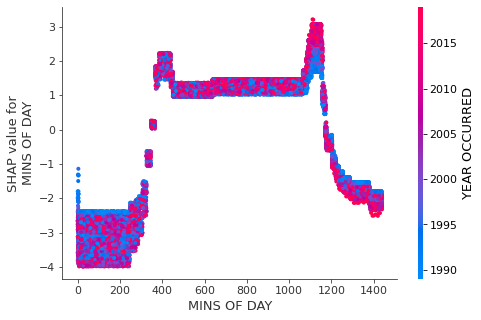

In [54]:
shap.initjs()
#police response time by time of day
shap.dependence_plot("MINS OF DAY", shap_values, X_validation, x_jitter=1)


Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


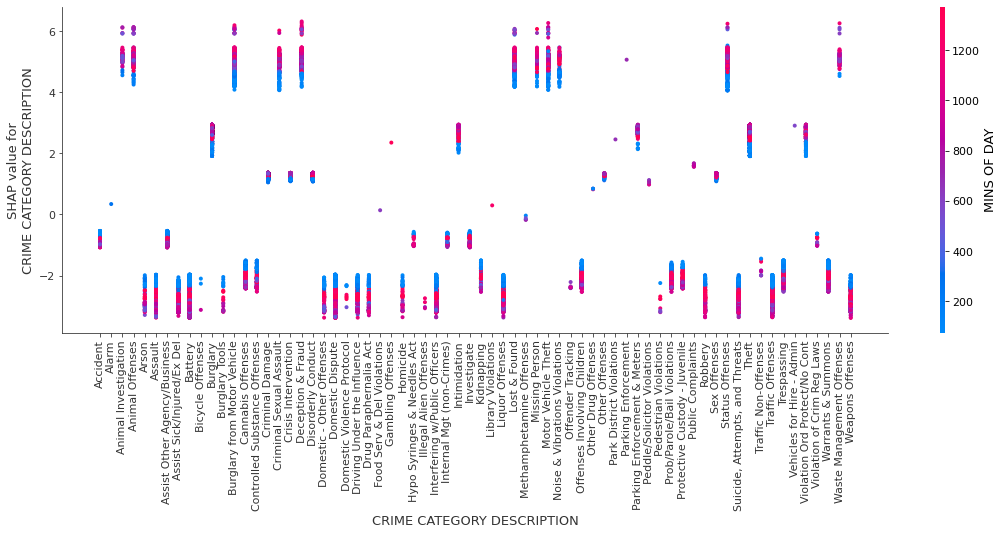

In [55]:
shap.initjs()


x = shap.dependence_plot("CRIME CATEGORY DESCRIPTION", shap_values, X_validation, interaction_index="MINS OF DAY",show=False)
fig = plt.gcf()
fig.set_size_inches(18.5, 6)
plt.savefig('shap-chart-crime-cat')

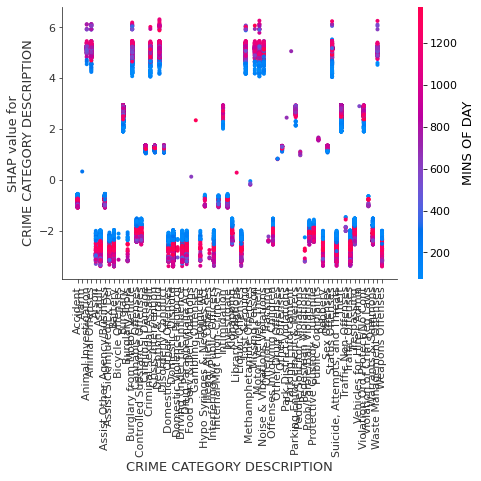

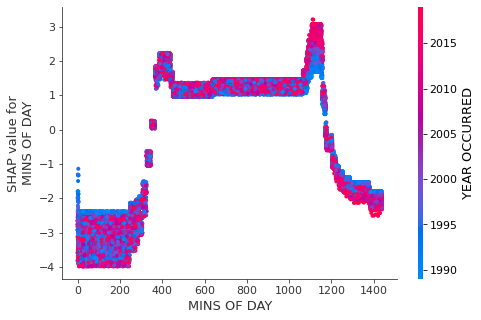

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


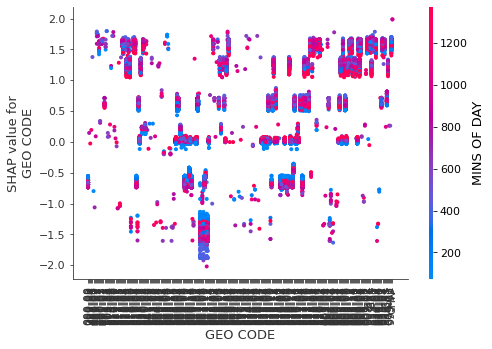

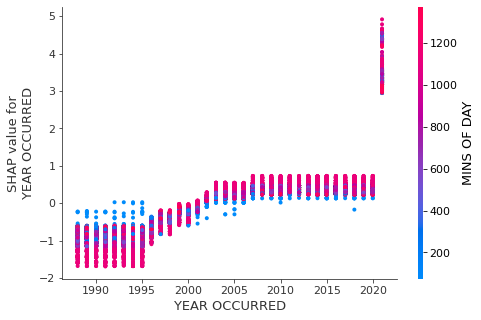

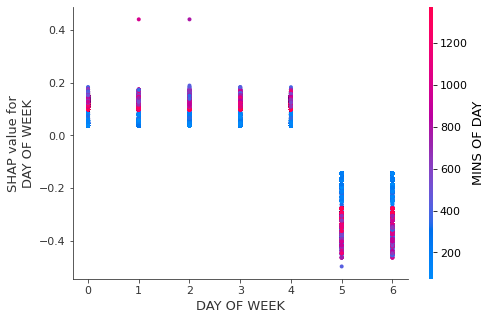

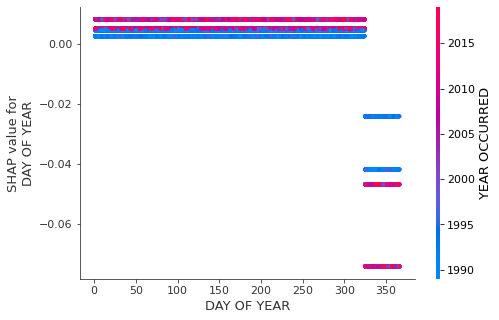

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


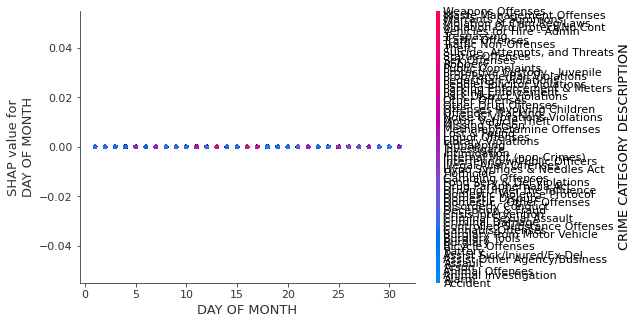

In [56]:
#show every dependece graph
for i in range(7):
    shap.dependence_plot("rank("+str(i)+")", shap_values, X_validation)

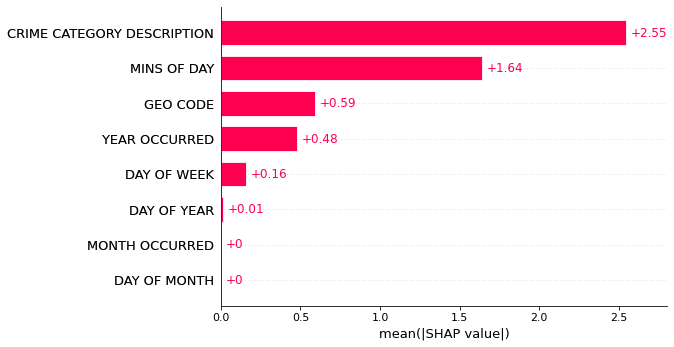

In [57]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.bar(shap_values)

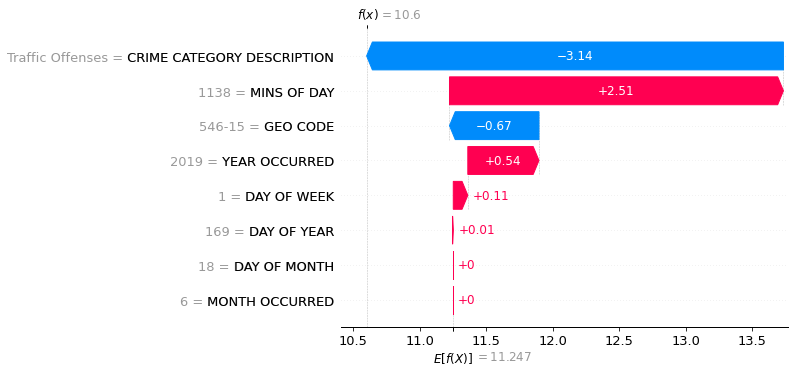

In [58]:
shap.plots.waterfall(shap_values[0])

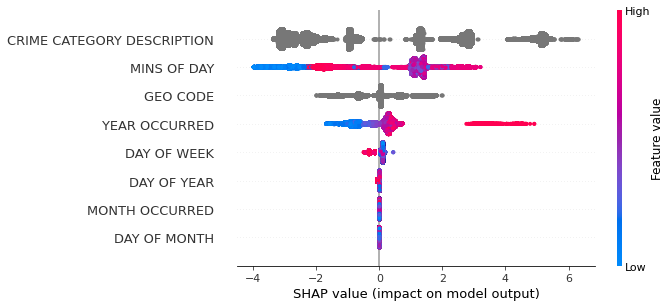

In [59]:
shap.plots.beeswarm(shap_values)

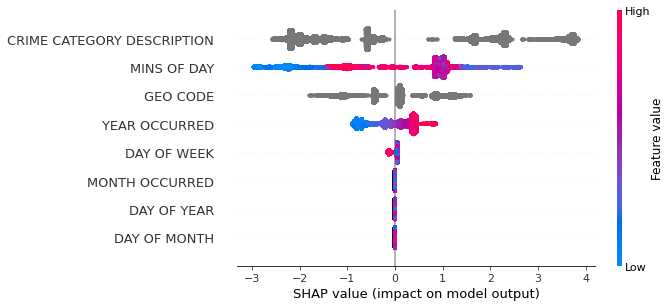

In [36]:
shap.summary_plot(shap_values)